# How to Train Segformer on Custom Data

This notebook shows training on **your own custom masks** for the SegFormer model as implemented in [the SegFormer paper](https://arxiv.org/pdf/2105.15203.pdf).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train Segformer](blog.roboflow.com/how-to-train-segformer-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

* Install SegFormer dependencies
* Download custom SegFormer semantic segmentation data
* Run SegFormer training
* Evaluate SegFormer performance
* Run SegFormer inference on test images

### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)

In [1]:
!pip install -q pytorch-lightning==2.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 39.8 MB/s eta 0:00:00


In [2]:
!pip install -q transformers==4.46.2 datasets==2.21.0 roboflow==1.1.49

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.6.1 which is incompatible.


In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random

In [4]:
import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("paul-guerrie-tang1").project("balloons-geknh")
dataset = project.version(1).download("png-mask-semantic")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Balloons-1 in png-mask-semantic:: 100%|██████████| 155/155 [00:00<00:00, 7034.76it/s]


In [5]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        self.id2label = {x[0]:x[1] for x in data}

        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]

        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [6]:
class SegformerFinetuner(pl.LightningModule):

    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            return_dict=False,
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )

        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")

        self.validation_step_outputs = []

    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return outputs

    def training_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes,
                ignore_index=255,
                reduce_labels=False,
            )

            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}

            for k,v in metrics.items():
                self.log(k,v)

            return(metrics)
        else:
            return({'loss': loss})

    def validation_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        self.validation_step_outputs.append({'val_loss': loss})

        return({'val_loss': loss})

    def on_validation_epoch_end(self):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_val_loss = torch.stack([x["val_loss"] for x in self.validation_step_outputs]).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        self.validation_step_outputs.clear()

        return metrics

    def test_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        return({'test_loss': loss})

    def test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}

        for k,v in metrics.items():
            self.log(k,v)

        return metrics

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl




In [7]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.do_reduce_labels = False
feature_extractor.size = 128

train_dataset = SemanticSegmentationDataset(f"{dataset.location}/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset(f"{dataset.location}/valid/", feature_extractor)
test_dataset = SemanticSegmentationDataset(f"{dataset.location}/test/", feature_extractor)

batch_size = 8
num_workers = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10,
)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


The repository for mean_iou contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mean_iou.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=500,
    val_check_interval=len(train_dataloader),
)
trainer.fit(segformer_finetuner)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
res = trainer.test(ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=100-step=707.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=100-step=707.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.10977981984615326    │
│    test_mean_accuracy     │    0.9071347586424672     │
│       test_mean_iou       │    0.8576631806112022     │
└───────────────────────────┴───────────────────────────┘

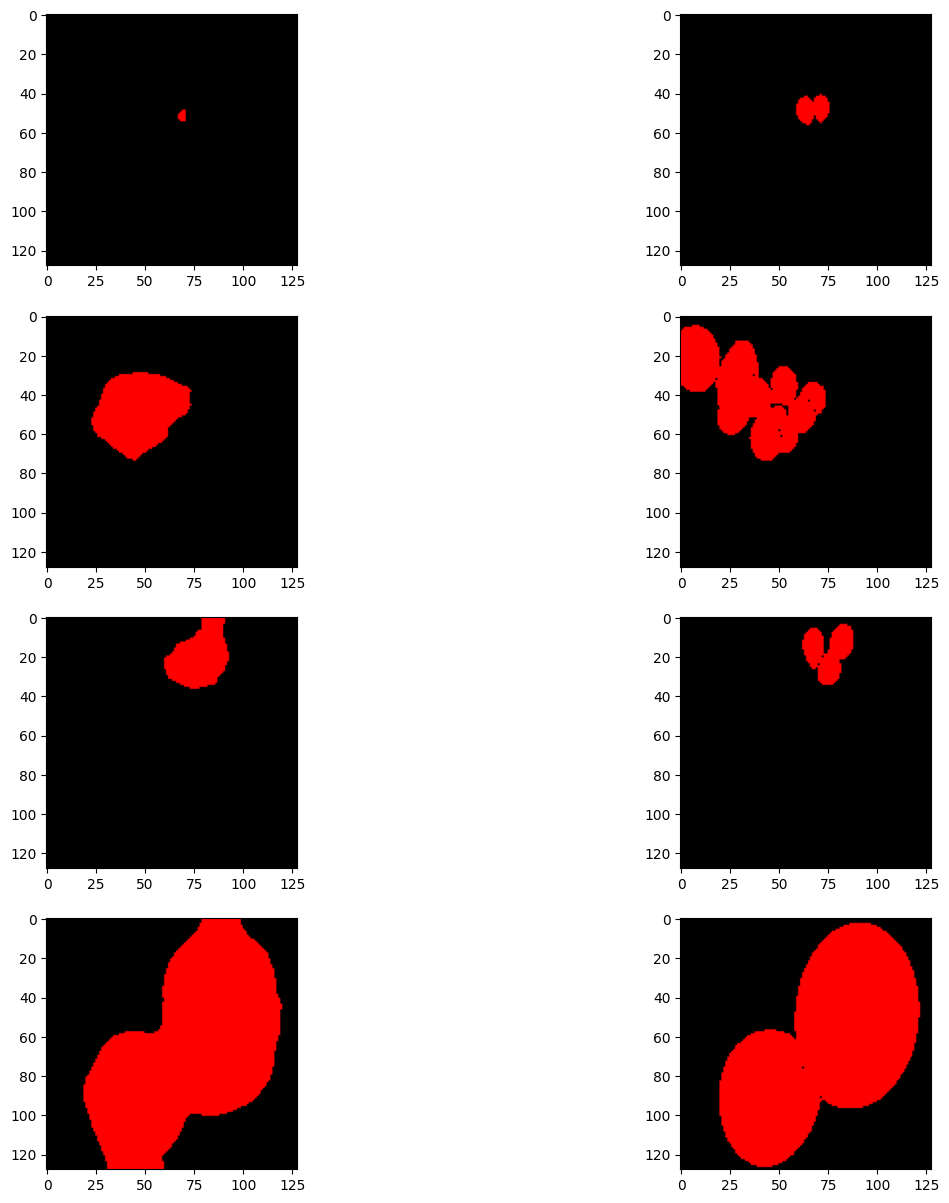

In [ ]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in test_dataloader:
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)

    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

n_plots = 4
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))


In [ ]:
#Predict on a test image and overlay the mask on the original image
test_idx = 0
input_image_file = os.path.join(test_dataset.root_dir,test_dataset.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, masks = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = segformer_finetuner.model(images, masks)

loss, logits = outputs[0], outputs[1]

upsampled_logits = nn.functional.interpolate(
    logits,
    size=masks.shape[-2:],
    mode="bilinear",
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(masks))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)

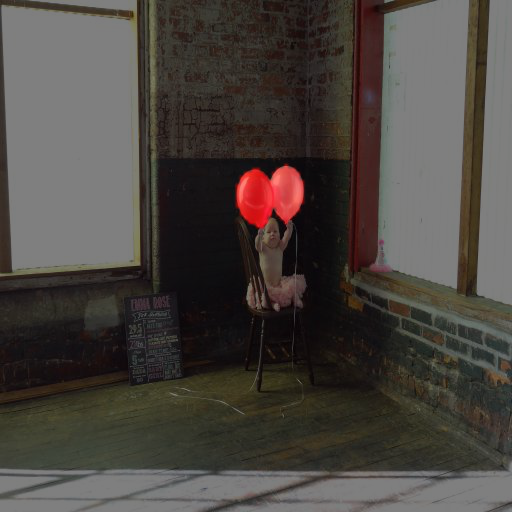

In [ ]:
overlay_img